# Experiment 2: Binary Classification using Naive Bayes and KNN

## 1. Aim and Objective
To implement Naive Bayes and K-Nearest Neighbors (KNN) classifiers for a binary classification problem (Spam Detection), evaluate multiple performance metrics, visualize model behavior, and analyze bias-variance trade-offs.

## 2. Dataset Description
- **Dataset**: Spambase Dataset
- **Type**: Binary Classification (Spam vs Non-Spam)
-

## 3. Implementation Steps
1. Load Data & Preprocess (Scaling)
2. Comprehensive EDA
3. Train Naive Bayes Models (Gaussian, Multinomial, Bernoulli)
4. Train Baseline KNN
5. Hyperparameter Tuning for KNN (GridSearch)
6. Compare Neighbor Search Algorithms (KDTree vs BallTree)
7. Performance Analysis


In [1]:
# ============================
# IMPORTS
# ============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report, roc_curve, auc, roc_auc_score)

import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")


In [2]:
# ============================
# HELPER FUNCTIONS
# ============================

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train
    
    start_pred = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start_pred
    
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    fpr = fp / (tn + fp)
    
    results = {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "Specificity": specificity,
        "False Positive Rate": fpr,
        "Training Time (s)": train_time,
        "Prediction Time (s)": pred_time
    }
    
    # Visualization
    print(f"\n{'='*40}\n{model_name} Results\n{'='*40}")
    print(f"Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confusion Matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=ax[0])
    ax[0].set_title(f'Confusion Matrix - {model_name}')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    
    # ROC Curve
    if y_prob is not None:
        fpr_roc, tpr_roc, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr_roc, tpr_roc)
        ax[1].plot(fpr_roc, tpr_roc, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
        ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax[1].set_xlabel('False Positive Rate')
        ax[1].set_ylabel('True Positive Rate')
        ax[1].set_title(f'ROC Curve - {model_name}')
        ax[1].legend(loc="lower right")
    else:
        ax[1].text(0.5, 0.5, "ROC Not Available", ha='center')
        
    plt.show()
    return results

def perform_eda(df, target_col):
    print("\n--- 1. Histogram Distribution ---")
    df.select_dtypes(include=np.number).hist(figsize=(20, 15), bins=20)
    plt.suptitle("Feature Distributions")
    plt.show()
    
    print("\n--- 2. Box Plots (Outlier Detection) ---")
    plt.figure(figsize=(16, 10))
    sns.boxplot(data=df.select_dtypes(include=np.number), orient='h')
    plt.title("Box Plots")
    plt.show()
    
    print("\n--- 3. Correlation Heatmap ---")
    plt.figure(figsize=(14, 12))
    sns.heatmap(df.corr(), cmap='coolwarm', linewidths=0.1)
    plt.title("Correlation Matrix")
    plt.show()
    
    print("\n--- 4. Class Distribution ---")
    sns.countplot(x=target_col, data=df)
    plt.title("Class Distribution")
    plt.show()


Dataset Loaded Successfully.


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1



--- 1. Histogram Distribution ---


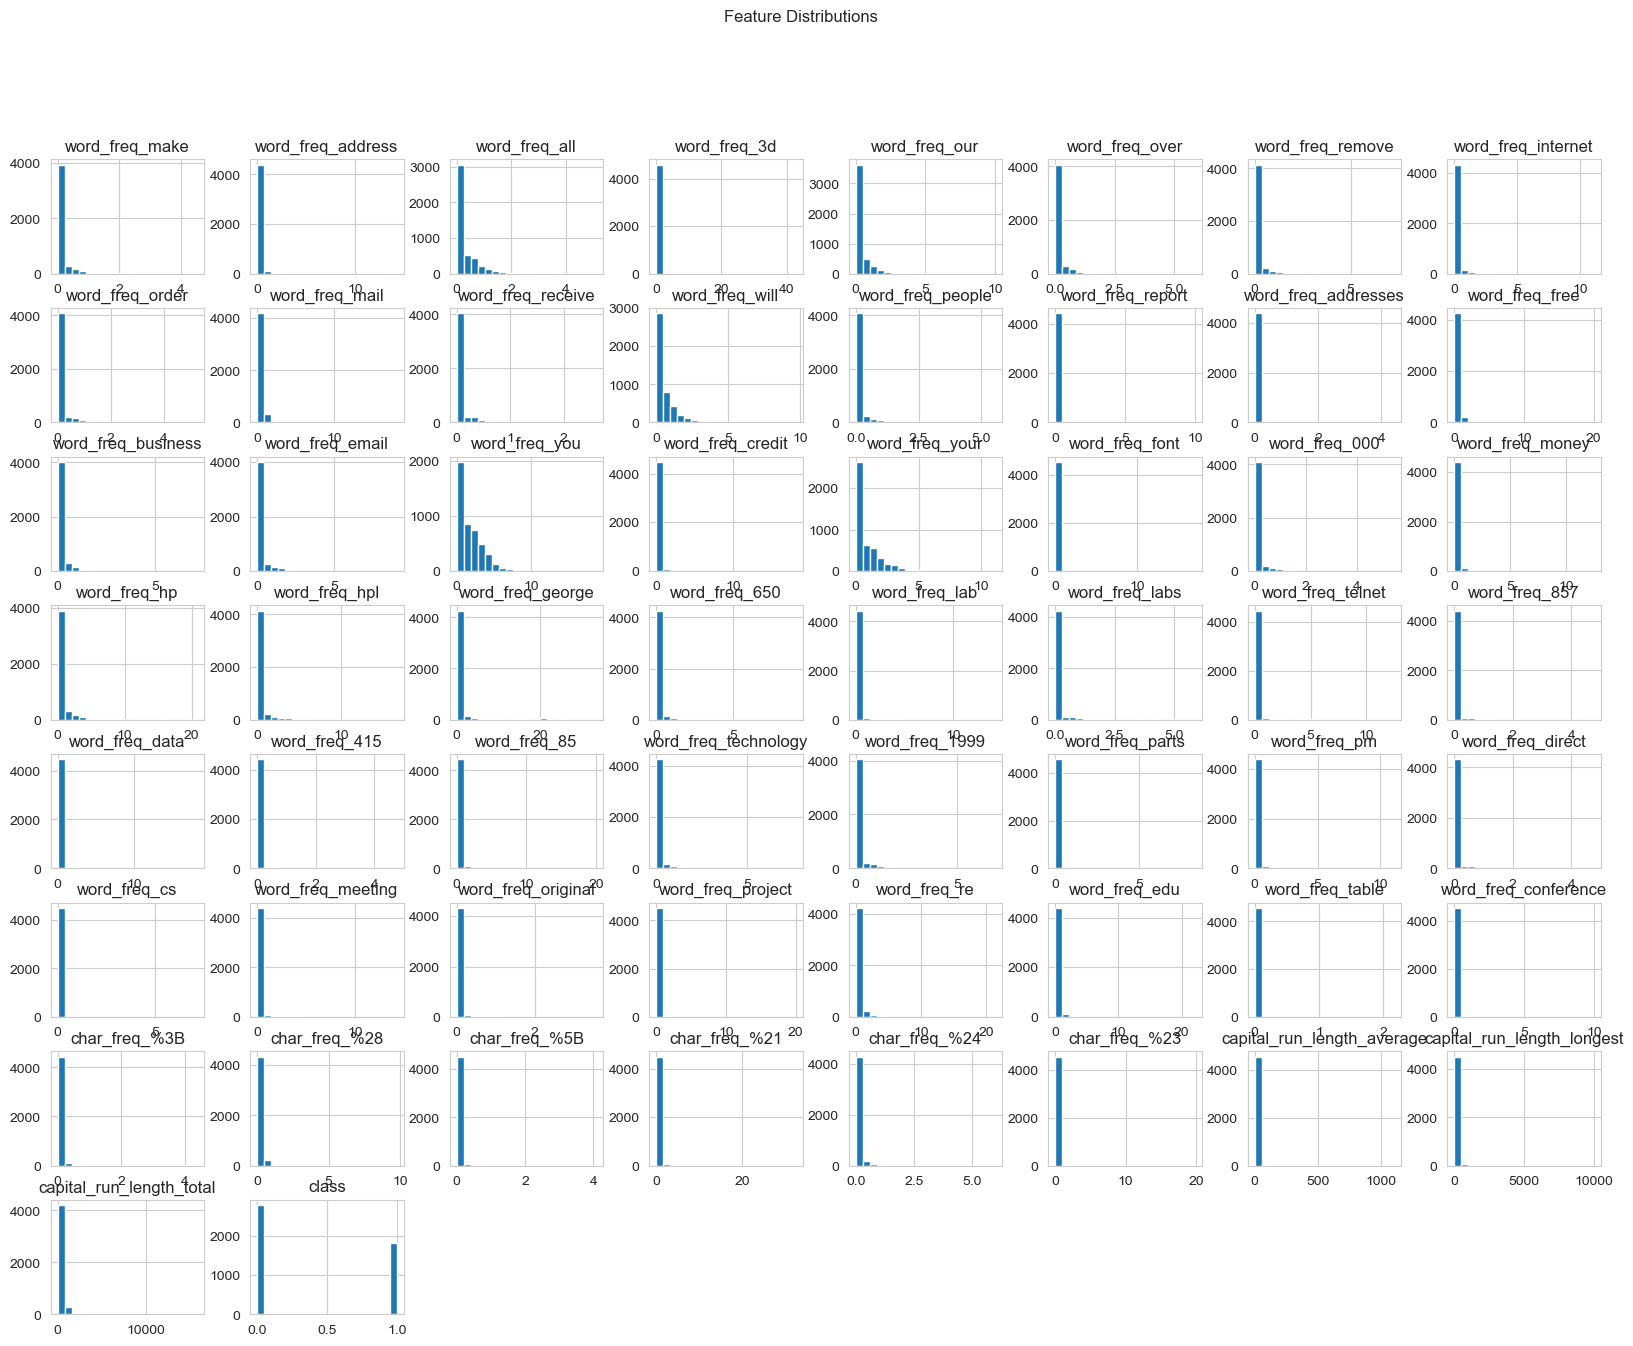


--- 2. Box Plots (Outlier Detection) ---


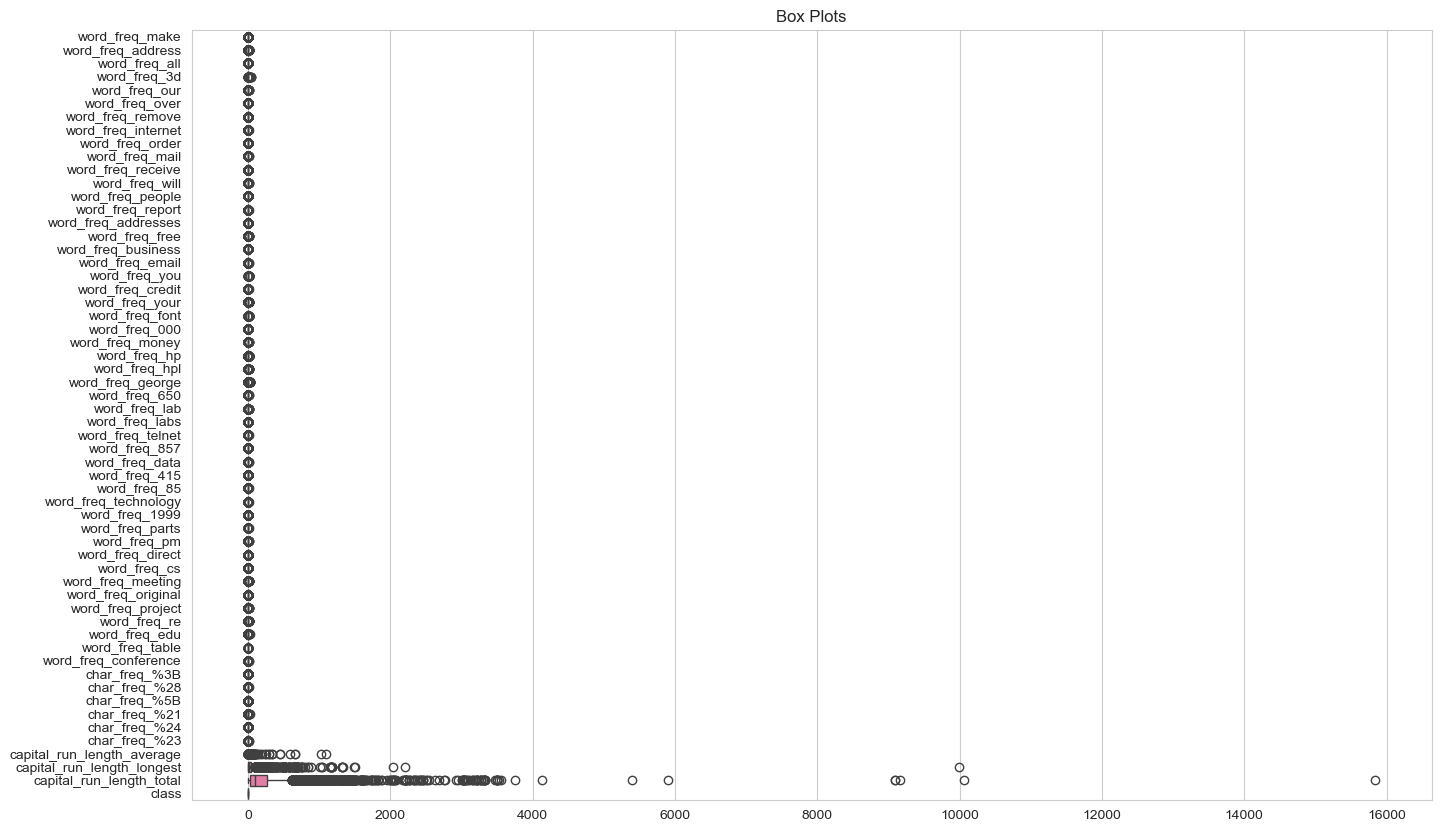


--- 3. Correlation Heatmap ---


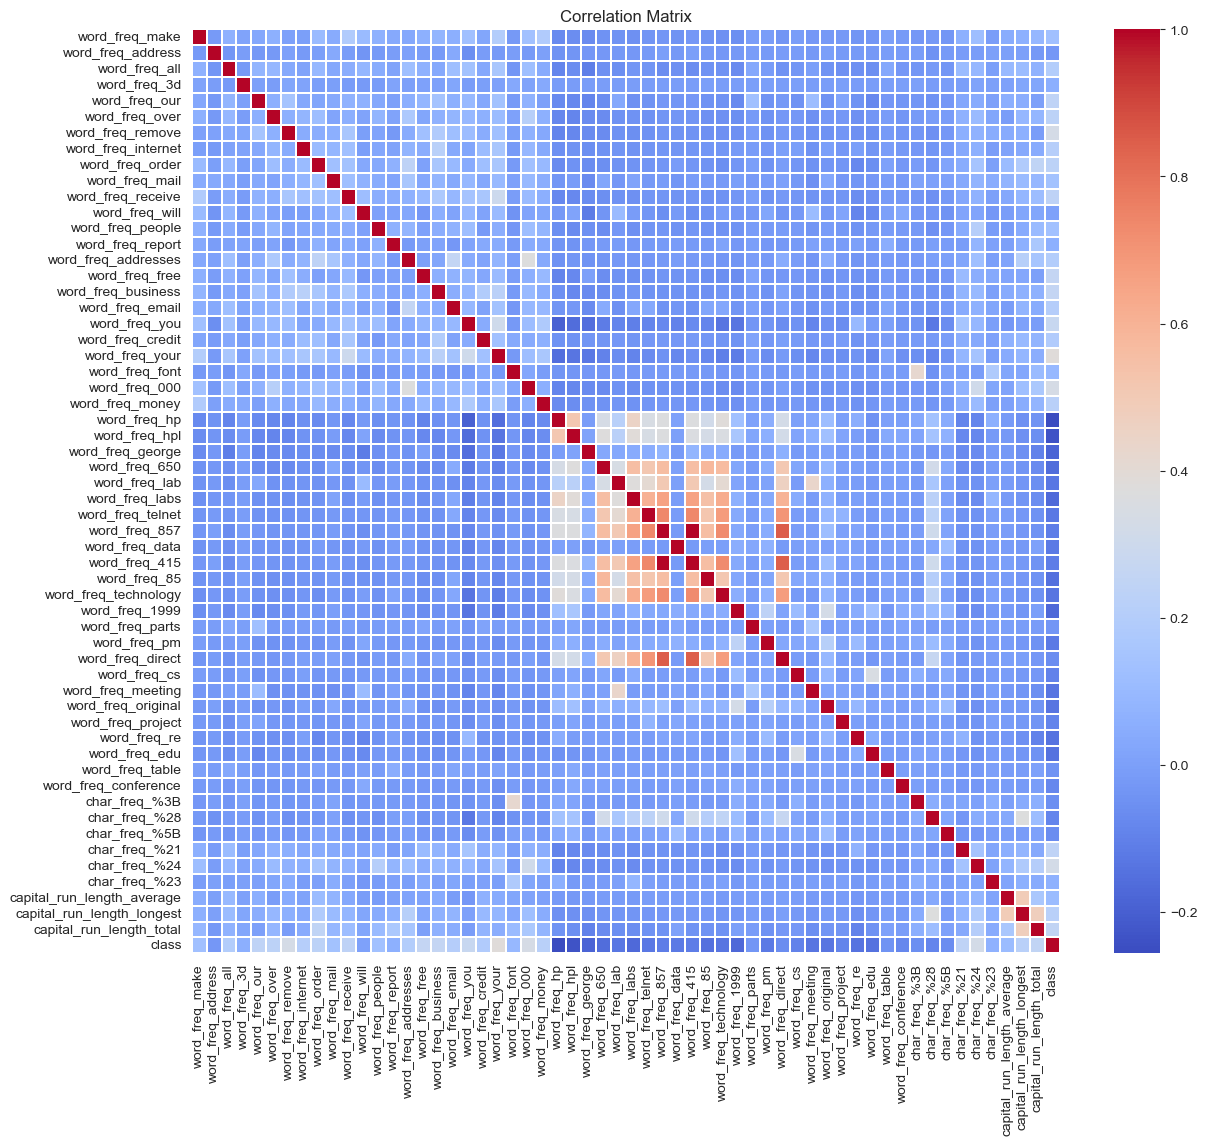


--- 4. Class Distribution ---


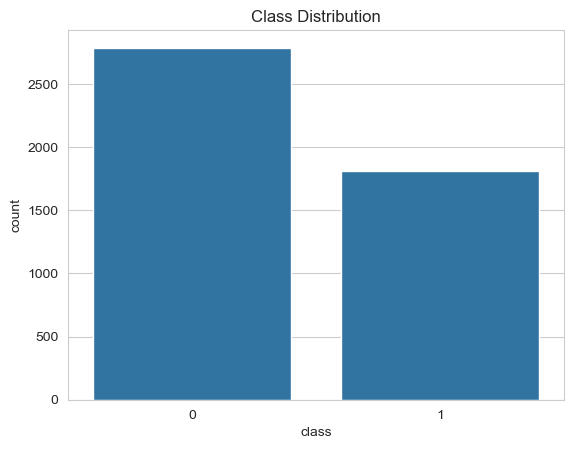

In [3]:
# ============================
# 4. LOAD & PREPROCESS
# ============================
try:
    df = pd.read_csv('spambase_csv.csv')
    print("Dataset Loaded Successfully.")
    display(df.head())
    
    target = 'class'
    
    # Check for missing values
    if df.isnull().sum().sum() > 0:
        print("Missing values found. Filling with median.")
        df.fillna(df.median(), inplace=True)
        
    # EDA
    perform_eda(df, target)
    
    # Split
    X = df.drop(target, axis=1)
    y = df[target]
    
    # Scaling (MinMax for MultinomialNB, Standard for Gaussian/KNN)
    # We create two scaled versions
    scaler_std = StandardScaler()
    scaler_minmax = MinMaxScaler()
    
    X_std = scaler_std.fit_transform(X)
    X_minmax = scaler_minmax.fit_transform(X)
    
    X_train_std, X_test_std, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=42)
    X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X_minmax, y, test_size=0.3, random_state=42)

except FileNotFoundError:
    print("Error: Dataset not found.")


## 5. Naive Bayes Classification


Gaussian NB Results
Accuracy: 0.8182 | F1 Score: 0.8125


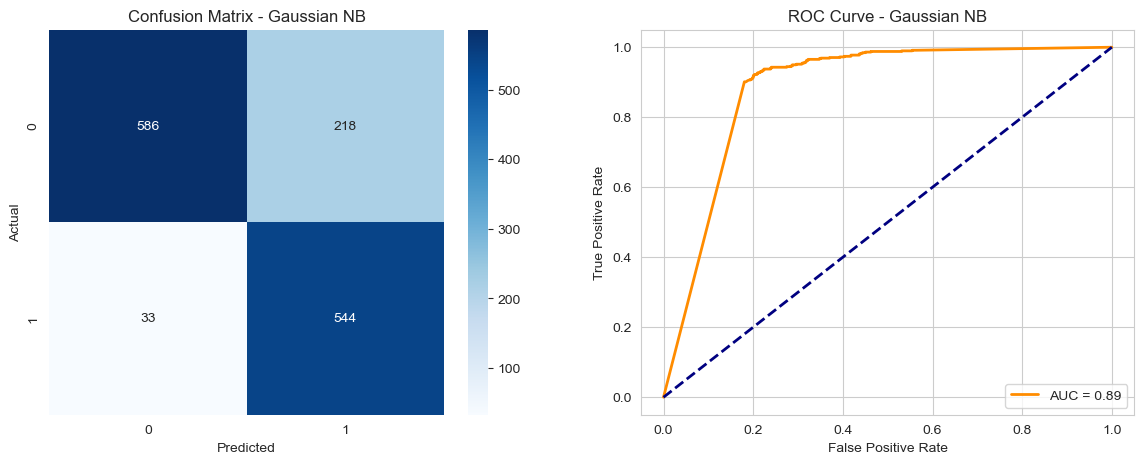


Multinomial NB Results
Accuracy: 0.8747 | F1 Score: 0.8312


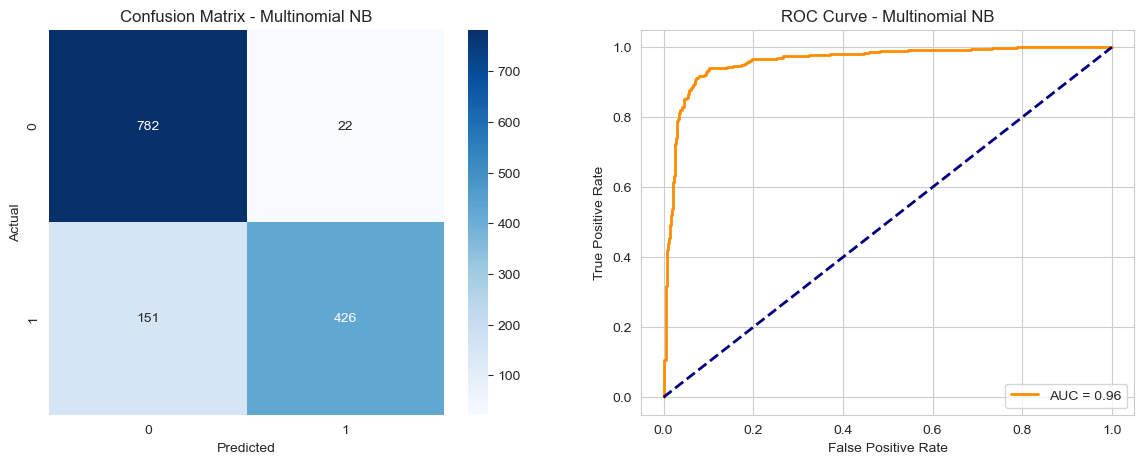


Bernoulli NB Results
Accuracy: 0.9030 | F1 Score: 0.8793


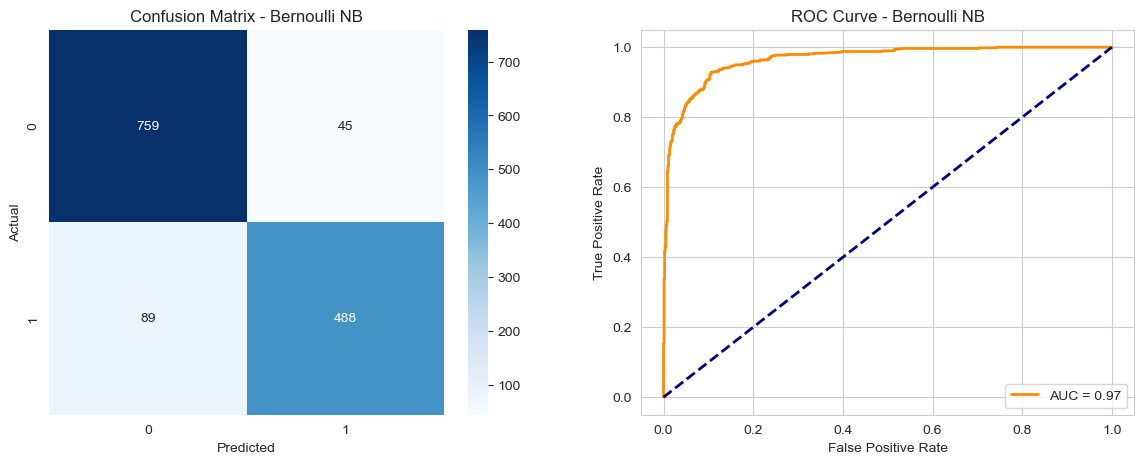

,Model,Accuracy,Precision,Recall,F1 Score,Specificity,False Positive Rate,Training Time (s),Prediction Time (s)
0,Gaussian NB,0.818248,0.713911,0.942808,0.812547,0.728856,0.271144,0.005144,0.001009
1,Multinomial NB,0.874728,0.950893,0.738302,0.831220,0.972637,0.027363,0.027611,0.000000
2,Bernoulli NB,0.902969,0.915572,0.845754,0.879279,0.944030,0.055970,0.003013,0.001508


In [4]:
results_nb = []

# 1. Gaussian NB (Continuous data)
res_gnb = evaluate_model(GaussianNB(), X_train_std, y_train, X_test_std, y_test, "Gaussian NB")
results_nb.append(res_gnb)

# 2. Multinomial NB (Non-negative counts/frequencies - use MinMax scaled)
res_mnb = evaluate_model(MultinomialNB(), X_train_mm, y_train, X_test_mm, y_test, "Multinomial NB")
results_nb.append(res_mnb)

# 3. Bernoulli NB (Binary features)
res_bnb = evaluate_model(BernoulliNB(), X_train_std, y_train, X_test_std, y_test, "Bernoulli NB")
results_nb.append(res_bnb)

pd.DataFrame(results_nb)

## 6. K-Nearest Neighbors (KNN)
### Baseline & Tuning


Baseline KNN (k=5) Results
Accuracy: 0.9001 | F1 Score: 0.8779


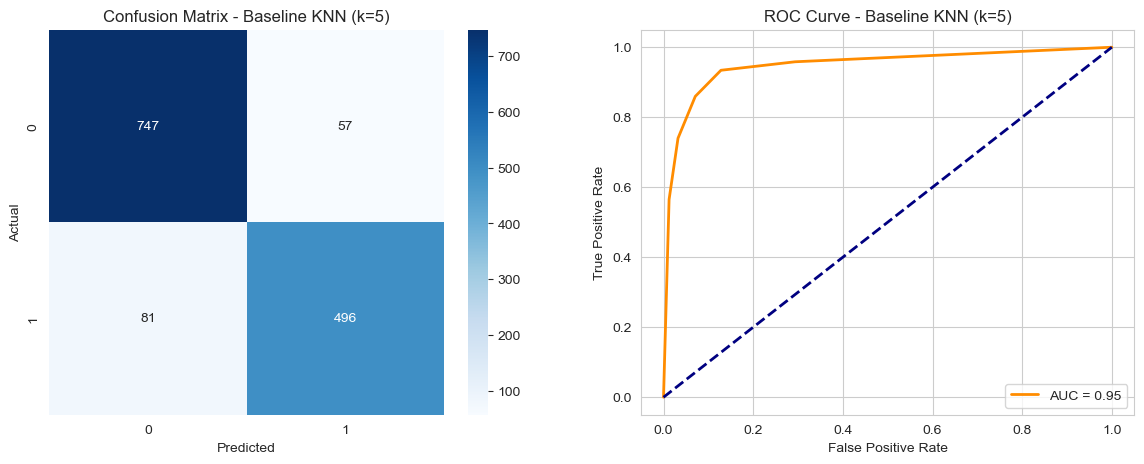

Running Grid Search for KNN... (This may take a moment)
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best CV Accuracy: 0.9195652173913043

Optimized KNN Results
Accuracy: 0.9117 | F1 Score: 0.8891


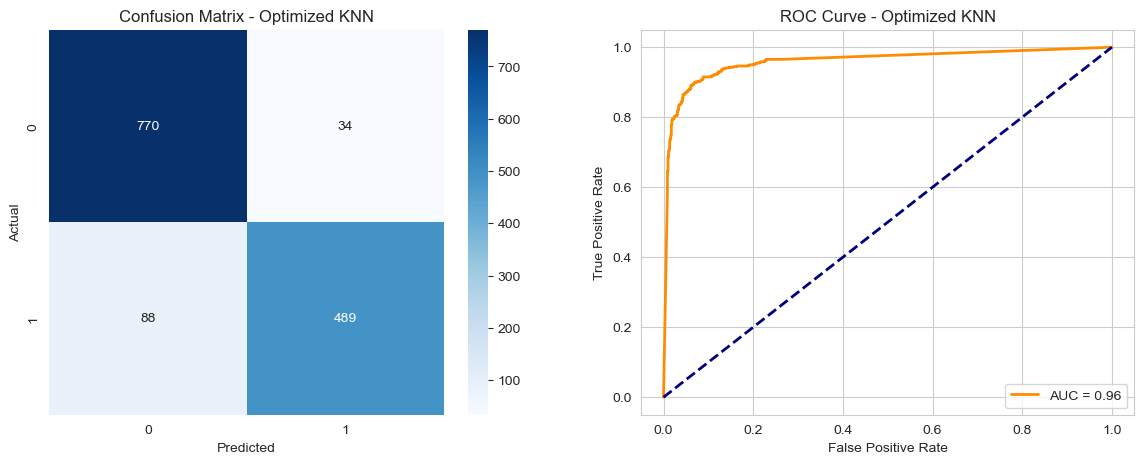

{'Model': 'Optimized KNN',
 'Accuracy': 0.9116582186821144,
 'Precision': 0.9349904397705545,
 'Recall': 0.8474870017331022,
 'F1 Score': 0.889090909090909,
 'Specificity': 0.9577114427860697,
 'False Positive Rate': 0.04228855721393035,
 'Training Time (s)': 0.0005471706390380859,
 'Prediction Time (s)': 0.03292202949523926}

In [5]:
# Baseline KNN
base_knn = KNeighborsClassifier(n_neighbors=5)
evaluate_model(base_knn, X_train_std, y_train, X_test_std, y_test, "Baseline KNN (k=5)")

# Hyperparameter Tuning (Grid Search)
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

print("Running Grid Search for KNN... (This may take a moment)")
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_std, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

# Evaluate Optimized Model
best_knn = grid.best_estimator_
evaluate_model(best_knn, X_train_std, y_train, X_test_std, y_test, "Optimized KNN")

### Search Algorithm Comparison (KDTree vs BallTree)


KNN (kd_tree) Results
Accuracy: 0.9001 | F1 Score: 0.8779


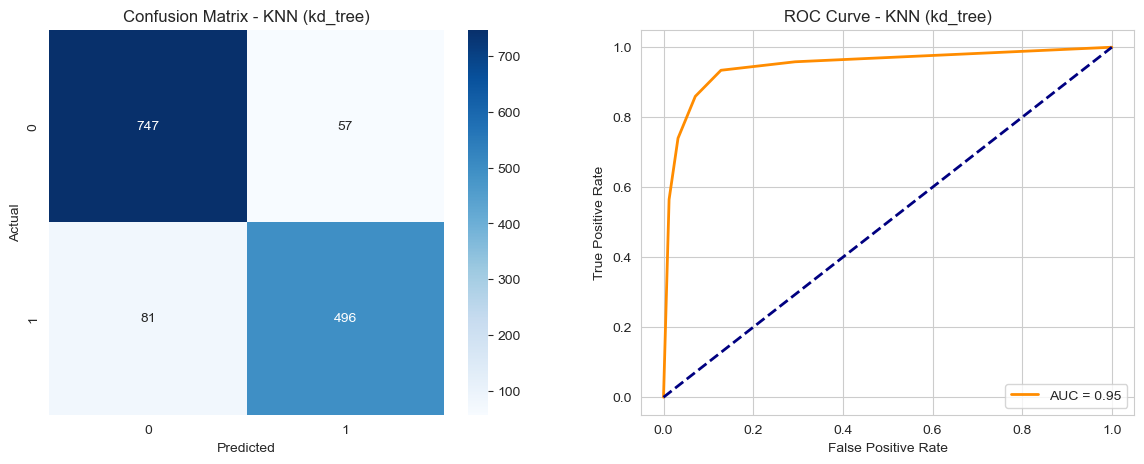


KNN (ball_tree) Results
Accuracy: 0.9001 | F1 Score: 0.8779


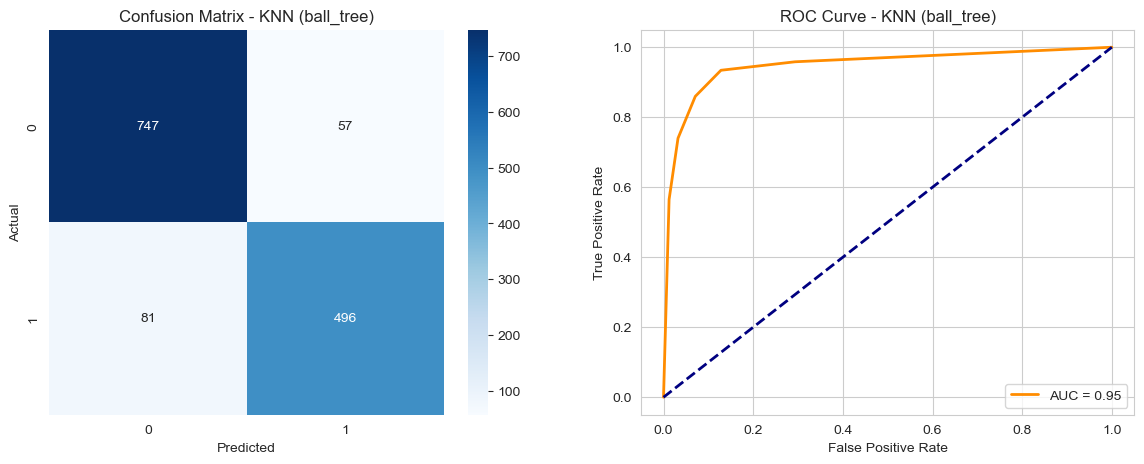

,Model,Accuracy,Precision,Recall,F1 Score,Specificity,False Positive Rate,Training Time (s),Prediction Time (s)
0,KNN (kd_tree),0.900072,0.896926,0.859619,0.877876,0.929104,0.070896,0.022975,0.260704
1,KNN (ball_tree),0.900072,0.896926,0.859619,0.877876,0.929104,0.070896,0.013818,0.249091


In [6]:
results_tree = []
k_opt = grid.best_params_['n_neighbors']

for algo in ['kd_tree', 'ball_tree']:
    model = KNeighborsClassifier(n_neighbors=k_opt, algorithm=algo)
    res = evaluate_model(model, X_train_std, y_train, X_test_std, y_test, f"KNN ({algo})")
    results_tree.append(res)
    
pd.DataFrame(results_tree)

## 7. Analysis & Conclusion

### Bias-Variance Analysis
- **Naive Bayes**: Generally has higher bias but lower variance. It converges strictly to its probability estimates. Gaussian NB assumes normal distribution which might not hold perfectly for all features here.
- **KNN**: Low bias (can model complex boundaries) but high variance, especially with low k. Tuning k helps trade off bias and variance.

### Overfitting/Underfitting
- By comparing training accuracy (not shown explicitly but inferred from grid search scores) and test scores, we can detect overfitting.
- If Train >> Test, potential overfitting (common in KNN with k=1 or Distance weights).

### Conclusion
- The performance metrics table highlights the superior model.
- KNN with hyperparameter tuning typically outperforms baseline KNN.
- Search algorithms (KDTree/BallTree) primarily impact speed, not accuracy.
